# Surface-Volume Reactions

<b>New topics</b>: Surface reactions, chained reactions, advanced ResultSelector usage, data saving to file.

## Model declaration

As in the previous chapter, we first import the required packages, create the `Model`, a `ReactionManager`, and declare `Species`:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

r = ReactionManager()

mdl = Model()

with mdl:
    Ca, IP3, R, RIP3, Ropen, RCa, R2Ca, R3Ca, R4Ca = Species.Create()
    surfsys = SurfaceSystem.Create()

## Surface reaction declaration

The last line of the previous code block declares a `SurfaceSystem` instead of a `VolumeSystem`. The reactions are then declared using the context manager `with` keyword, as previously seen:

In [2]:
with mdl, surfsys:
    # IP3 binding
    Surf(R)    + Out(IP3) <r['r1']> Surf(RIP3)
    Surf(RIP3) + Out(Ca)  <r['r2']> Surf(Ropen)
    r['r1'].setRates(1000e6, 25800)
    r['r2'].setRates(8000e6, 2000)

Surface reactions are declared in the same way as volume reactions except that each reactant needs to be localized either on the surface, inside, or outside of the patch. This can be done using the `SURF`, `IN`, and `OUT` functions, as we did for the first two reactions.

The same reactions can be declared in a slightly more concised way:
```python
R.s + IP3.o <r[1]> RIP3.s
RIP3.s + Ca.o <r[2]> Ropen.s
```

Adding `.s`, `.i`, or `.o` after a reactant is a shorthand way to specify localization. This notation aims at imitating subscripts like in: $\mathrm{R_s + IP3_o \leftrightarrow RIP3_s}$

Finally, when several reactants bind sequentially (to a receptor like here for example), it is possible to chain the reactions using parentheses:
```python
(R.s + IP3.o <r[1]> RIP3.s) + Ca.o <r[2]> Ropen.s
```
Reactions that are in parentheses are equivalent to their right hand side. The above line thus first declares the reaction in the parentheses `R.s + IP3.o <r[1]> RIP3.s` and replaces it by its right hand side; the line then reads `RIP3.s + Ca.o <r[2]> Ropen.s` and this reaction is declared. The whole process is thus equivalent to declaring the reactions on two separate lines.
<div class="alert alert-block alert-warning">
    <b>Warning</b>
    Chained reactions can be a bit hard to read so their use should probably be restricted to sequential bindings.
</div>

We then declare the remaining reactions in a similar way:

In [3]:
with mdl, surfsys:
    # Ca binding
    (((R.s + Ca.o <r['r3']> RCa.s) + Ca.o <r['r4']> R2Ca.s) + Ca.o <r['r5']> R3Ca.s) + Ca.o <r['r6']> R4Ca.s
    r['r3'].setRates(8.889e6, 5)
    r['r4'].setRates(20e6, 10)
    r['r5'].setRates(40e6, 15)
    r['r6'].setRates(60e6, 20)

    # Ca ions passing through open IP3R channel
    Ca.i + Ropen.s >r[1]> Ropen.s + Ca.o
    r[1].setRates(2e8)

## Geometry declaration

Having declared all the surface reactions, we turn to defining the geometry:

In [4]:
geom = Geometry()
with geom:
    # Create the cytosol and Endoplasmic Reticulum compartments
    cyt, ER = Compartment.Create()
    cyt.Vol = 1.6572e-19
    ER.Vol = 1.968e-20

    # ER is the 'inner' compartment, cyt is the 'outer' compartment
    memb = Patch.Create(ER, cyt, surfsys)
    memb.Area = 0.4143e-12

Since we only defined a `SurfaceSystem` in the model, we do not need to associate our compartment with a `VolumeSystem`. We then create the `Patch` using the automatic naming syntax. This time, the `Create` method needs to receive at least the inner compartment. Additional parameters are:
```python
patchName = Patch.Create(innerComp, outerComp, surfSys, area)
```
The area of a patch can also be set after creation using `patch.Area = value`.

## Simulation declaration and data saving

This time, instead of saving the data to memory, like in the previous chapter, we will save it to files:

In [5]:
rng = RNG('mt19937', 512, 7233)

sim = Simulation('Wmdirect', mdl, geom, rng)

rs = ResultSelector(sim)

Rstates = rs.memb.MATCH('R.*').Count

Reacs = rs.memb.MATCH('r[1-6]')['fwd'].Extent + rs.memb.MATCH('r[1-6]')['bkw'].Extent

Rstates.labels = [l.split('.')[1] for l in Rstates.labels]

Rstates.toFile('Rstates.dat')
Reacs.toFile('Reacs.dat')

sim.toSave(Rstates, Reacs, dt=0.001)

Model checking:
No errors were found


This time we declare two different `ResultSelector`s, `Rstates` and `Reacs`, that will both be saved every `0.001`s. `Rstates` makes use of the `MATCH(...)` function that only selects objects whose name matches the [regular expression](https://docs.python.org/3/howto/regex.html) given as a parameter. In our case, it will match all objects inside `memb` whose name starts with 'R', i.e. all receptors. It is equivalent to the longer:
```python
Rstates = rs.memb.LIST(R, RIP3, Ropen, RCa, R2Ca, R3Ca, R4Ca).Count
```
In our specific case, it happens to be equivalent to `rs.memb.ALL(Species).Count` because we did not define any other species on the ER membrane. The `MATCH` version is however preferable since it will still work if we decide to add other species.

### Combining ResultSelectors

<img src="images/resultselector_syntax.png"/>

The second `ResultSelector`, `Reacs` will save the extent of each reaction from 'r1' to 'r6', taking into account both forward and backward subreactions. To understand its declaration, we first need to see how reactions interact with `ResultSelector`s.
The following `ResultSelector` will save both forward and backward extent of reaction 'r1':
```python
rs.memb.r1.Extent
```
Since it saves two values for each run and for each timestep (i.e. the third dimension of the associated data structure is 2, cf. previous tutorial), and for the sake of simplicity, we will say that it has length 2. To save specifically the forward extent, we write:
```python
rs.memb.r1['fwd'].Extent
```
and this `ResultSelector` has length 1. To save the total extent (the sum of forward and backward), one could write:
```python
rs.SUM(rs.memb.r1.Extent)
```
the `rs.SUM(...)` function takes a `ResultSelector` as an argument and returns a `ResultSelector` whose length is 1 and corresponds to the sum of all the values defined by the argument. In our case, it would be equivalent to:
```python
rs.memb.r1['fwd'].Extent + rs.memb.r1['bkw'].Extent
```
This `+` notation is also valid; standard arithmetic operators (`+`, `-`, `*`, `/`, and `**`) can all be used with `ResultSelector`s and behave in the same way as they do in numpy. The above example sums two `ResultSelector`s of length 1 and thus results in a `ResultSelector` of length one as well. If the length of the operands is higher than one, like in:
```python
rs.memb.LIST(r1, r2)['fwd'].Extent + rs.memb.LIST(r1, r2)['bkw'].Extent
```
the resulting `ResultSelector` has length 2, like the operands, and is equivalent to:
```python
rs.memb.r1['fwd'].Extent + rs.memb.r1['bkw'].Extent << rs.memb.r2['fwd'].Extent + rs.memb.r2['bkw'].Extent
```
In our main example, `Reacs` has length 6 and saves the total extent of each reaction whose name matches the regular expression 'r\[1-6\]' (the name has to start with character 'r' and then a number between 1 and 6).

As we saw in the previous tutorial, labels are automatically generated when using `ResultSelector`s and can be accessed with e.g. `Rstates.labels`. With the same notation, it is also possible to provide custom labels by simply using:
```python
selector.labels = ['label 1', 'label2', ...]
```
The length of the list needs to match the length of the `ResultSelector`. In our specific example, we modify the automatically generated labels (`memb.R.Count`, `memb.RIP3.Count`, etc.) to only keep the species name.

Finally, in order to save the data to files, we simply need to call the `toFile` method on the `ResultSelector` object and provide it with the file path. The data from all runs will be saved to the same file in binary format. We then need to remember to associate both `ResultSelector`s to the simulation and specify how frequently they should be saved. If they need to be saved a different intervals, we could of course write:
```python
sim.toSave(Rstates, dt=0.001)
sim.toSave(Reacs, dt=0.005)
```
In addition, if we wanted to save the data at specified timepoints, we could use the `timePoints` argument:
```python
sim.toSave(Reacs, timePoints=[0.0, 0.01, 0.03, 0.15])
```

Having defined all `ResultSelector`s, we can then run the simulation:

In [6]:
NITER = 100
ENDT = 0.201

for i in range (0, NITER):
    sim.newRun()

    sim.cyt.Ca.Conc = 3.30657e-8
    sim.cyt.IP3.Count = 6
    sim.ER.Ca.Conc = 150e-6
    sim.ER.Ca.Clamped = True
    sim.memb.R.Count = 160

    sim.run(ENDT)

Let us then assume that the previous code was executed on a computing machine and the following code is executed on a distinct machine. To emulate this, we can reset the jupyter kernel with:

In [7]:
%reset -f

Now we do not have access to the variables we declared previously and thus cannot plot data using `Rstates.data` like we did before. Instead, we first need to load the files to which we saved the data:

In [8]:
import steps.interface

from steps.saving import *
from matplotlib import pyplot as plt
import numpy as np

ldRstates = ResultSelector.FromFile('Rstates.dat')
ldReacs   = ResultSelector.FromFile('Reacs.dat')

The `ldRstates` and `ldReacs` objects now behave like the `Rstates` and `ldReacs` objects in the simulation script, we can thus use them transparently to plot the data. We will first plot the time course of the number of receptors in the open state:

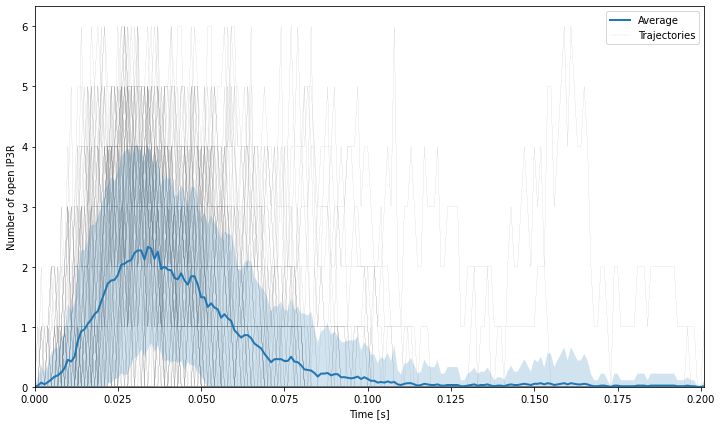

In [9]:
plt.figure(figsize=(12,7))

RopenInd = ldRstates.labels.index('Ropen')
RopenData = ldRstates.data[:, :, RopenInd]

time = ldRstates.time[0]
mean = np.mean(RopenData, axis=0)
std = np.std(RopenData, axis=0)

plt.plot(time, mean, linewidth=2)
plt.fill_between(time, mean - std, mean + std, alpha=0.2)

for t, d in zip(ldRstates.time, RopenData):
    plt.plot(t, d, color='grey', linewidth=0.1, zorder=-1)

plt.ylim(0)
plt.margins(0, 0.05)
plt.xlabel('Time [s]')
plt.ylabel('Number of open IP3R')
plt.legend(['Average', 'Trajectories'])
plt.show()

We first need to extract the data for `Ropen` from `ldRstates`. We do so by using `ldRstates.labels`; we are interested in `memb.Ropen.Count` so we simply call the python `index` method that returns the index of the `Ropen` data in the whole selector.
We then get the corresponding data with `ldRstates.data[:, :, RopenInd]`, the two first dimensions (runs and time) are untouched and we only take the data relative to `Ropen`.

In order to display the trace corresponding to each run, we iterate on the data with:
```python
for t, d in zip(ldRstates.time, RopenData):
    plt.plot(t, d, color='grey', linewidth=0.1, zorder=-1)
```

We would then like to look at the time course of all receptor states:

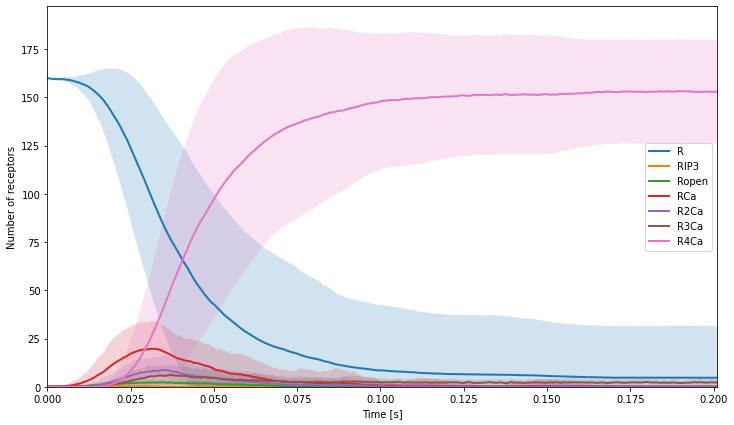

In [10]:
plt.figure(figsize=(12,7))

time = ldRstates.time[0]
mean = np.mean(ldRstates.data, axis=0)
std = np.std(ldRstates.data, axis=0)

plt.plot(time, mean, linewidth=2)
for m, s in zip(mean.T, std.T):
    plt.fill_between(time, m - s, m + s, alpha=0.2)

plt.legend(ldRstates.labels)
plt.xlabel('Time [s]')
plt.ylabel('Number of receptors')
plt.ylim(0)
plt.margins(0, 0.05)
plt.show()

Since `fill_between` cannot take all data at once, like `plot` can, we needed to iterate over the different receptor states in `mean` and `std`. To do so, we used:
```python
for m, s in zip(mean.T, std.T):
    plt.fill_between(time, m - s, m + s, alpha=0.2)
```
both `mean` and `std` have dimension `(nbT, nbR)` with `nbT` the number of saved time points and `nbR` the number of receptor states. Since the first dimension corresponds to time, if we were to directly iterate over `mean` and `std`, we would iterate over time instead of iterating over receptor states. We thus first transpose the matrices with `mean.T` and `std.T`.

We then turn to plotting data from `ldReacs`:

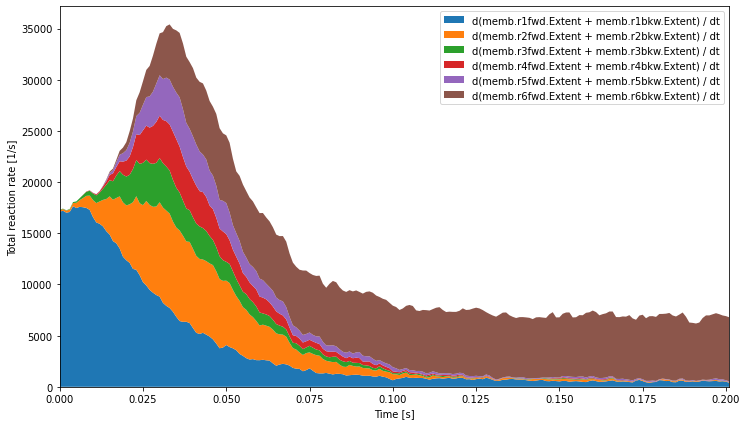

In [11]:
plt.figure(figsize=(12,7))

time = ldReacs.time[0]
dt = time[1] - time[0]
meanDeriv = np.mean(np.gradient(ldReacs.data, dt, axis=1), axis=0)

plt.stackplot(time, meanDeriv.T)

plt.legend([f'd{l} / dt' for l in ldReacs.labels])
plt.margins(0, 0.05)
plt.xlabel('Time [s]')
plt.ylabel('Total reaction rate [1/s]')
plt.show()

Here we want to look at the repartition of the actual rates of reactions. We use the [`np.gradient`](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html) function that computes the derivative of the data with respect to the time axis (`axis=1`). We then average the values across runs using `np.mean` with `axis=0`. This time derivative of the extent of each reaction is a good proxy for the instantaneous actual rate of this reaction.